In [173]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
import neattext.functions as nfx
import warnings
warnings.filterwarnings('ignore')


#https://www.kaggle.com/code/pashupatigupta/starter-notebook-a-to-z-emotion-detection

In [174]:
df=pd.read_csv('dataset/isear.csv')

In [175]:
df

,Emotion,Text
0,joy,"During the period of falling in love, each tim..."
1,fear,When I was involved in a traffic accident.
2,anger,When I was driving home after several days of...
3,sadness,When I lost the person who meant the most to me.
4,disgust,The time I knocked a deer down - the sight of ...
...,...,...
7468,anger,Two years back someone invited me to be the tu...
7469,sadness,I had taken the responsibility to do something...
7470,disgust,I was at home and I heard a loud sound of spit...
7471,shame,I did not do the homework that the teacher had...


In [176]:
df['Emotion'].value_counts()

joy        1081
fear       1081
anger      1071
sadness    1067
disgust    1067
shame      1054
guilt      1052
Name: Emotion, dtype: int64

In [177]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [178]:

df['Clean_Text']=df['Text'].apply(nfx.remove_special_characters)

In [179]:
df['Clean_Text']=df['Clean_Text'].apply(nfx.remove_punctuations)

In [180]:
df['Clean_Text']=df['Clean_Text'].apply(nfx.remove_stopwords)

In [181]:
df['Clean_Text']=df['Clean_Text'].apply(nfx.remove_userhandles)

In [182]:
df[['Text','Clean_Text']]

,Text,Clean_Text
0,"During the period of falling in love, each tim...",period falling love time met especially met lo...
1,When I was involved in a traffic accident.,involved traffic accident
2,When I was driving home after several days of...,driving home days hard work motorist ahead dri...
3,When I lost the person who meant the most to me.,lost person meant
4,The time I knocked a deer down - the sight of ...,time knocked deer sight animals injuries helpl...
...,...,...
7468,Two years back someone invited me to be the tu...,years invited tutor granddaughter granddaughte...
7469,I had taken the responsibility to do something...,taken responsibility prepared failed timidity ...
7470,I was at home and I heard a loud sound of spit...,home heard loud sound spitting outside door th...
7471,I did not do the homework that the teacher had...,homework teacher asked scolded immediately


In [183]:
from keras.layers import Dropout, Dense, GRU, Embedding, LSTM, Bidirectional, TimeDistributed, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Logging
import logging
logging.basicConfig(level=logging.INFO)

In [184]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    
    f = open("glove.6B.50d.txt", encoding='utf-8')
    for line in f:
        try:
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
            except:
                pass
            embeddings_index[word] = coefs
        except UnicodeDecodeError:
            pass
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index, tokenizer)

In [185]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=60, EMBEDDING_DIM=50, dropout=0.5):
    # Model building
    model = Sequential()
    hidden_layer = 2
    lstm_node = 32
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(lstm_node)
    for i in range(0,hidden_layer):
        model.add(Bidirectional(LSTM(lstm_node,return_sequences=True, recurrent_dropout=0.5)))
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.5)))
    model.add(Dropout(dropout))
    #model.add(TimeDistributed(Dense(256)))
    #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [211]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def class_balance(df, target):
  cls = df[target].value_counts()
  cls.plot(kind='bar')
  plt.show()

In [212]:
preprocess = True
text = 'Clean_Text'
target = 'Emotion'
MAX_SEQUENCE_LENGTH = 60

In [213]:
train_final = df[['Clean_Text', 'Emotion']]
print("Train DataFrame")
display(train_final.head(3))

Train DataFrame


,Clean_Text,Emotion
0,period falling love time met especially met lo...,4
1,involved traffic accident,2
2,driving home days hard work motorist ahead dri...,0


In [214]:
le = LabelEncoder()
train_final['Emotion'] = le.fit_transform(train_final['Emotion'])

## df for training and prediction
df = train_final

In [215]:

from sklearn.model_selection import train_test_split

X = df[text]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("Generating Glove Embeddings...")
X_train_Glove,X_test_Glove, word_index,embeddings_index, tokenizer = loadData_Tokenizer(X_train,X_test, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH)

Generating Glove Embeddings...
Found 9050 unique tokens.
(7473, 60)
Total 400000 word vectors.


In [216]:
with warnings.catch_warnings():
    print("Building Model ...")
    model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 60)
    model_RNN.summary()
    print("\n Starting Training ... \n")
    history = model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=5,
                              batch_size=128,
                              verbose=1)
    warnings.simplefilter("ignore")

Building Model ...
32
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 60, 50)            452550    
                                                                 
 bidirectional_15 (Bidirecti  (None, 60, 64)           21248     
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 60, 64)            0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 60, 64)           24832     
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 60, 64)            0         
                                                                 
 bidirectional_17 (Bidirecti  (N


 Plotting results ... 



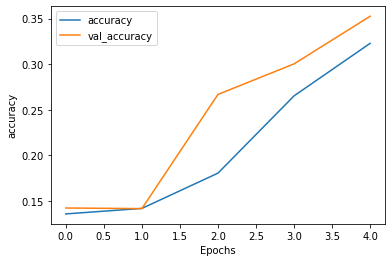

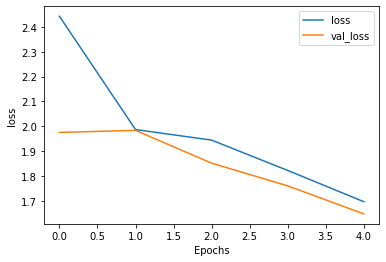


 Evaluating Model ... 

Confusion Matrix


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [221]:


#print(predicted)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

print("\n Plotting results ... \n")
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
print("\n Evaluating Model ... \n")




predicted = model_RNN.predict(X_test_Glove)
print('Confusion Matrix')
print(metrics.classification_report(y_test, predicted))